# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [3]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [5]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [6]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Number of images:  50
50


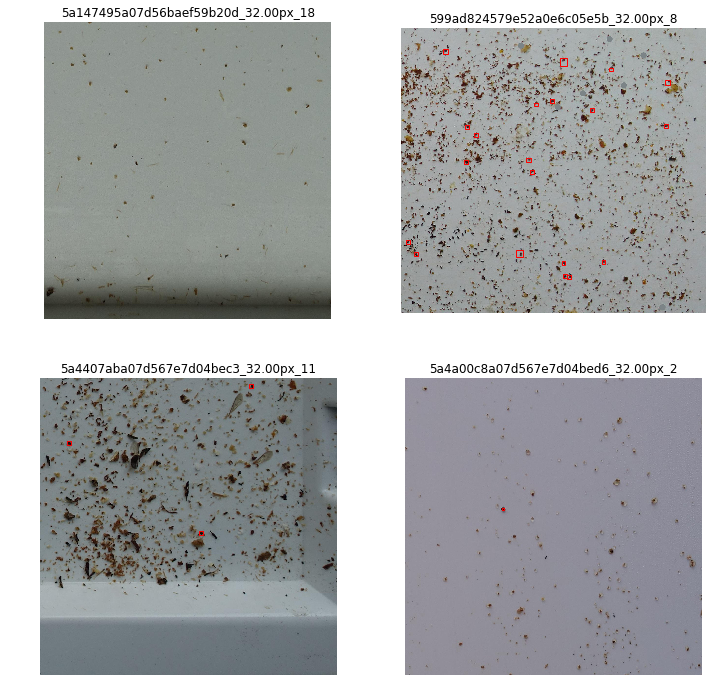

In [7]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gzip
from sklearn.metrics import confusion_matrix

import tarfile
import scipy.io

import skimage.io
import matplotlib.patches as patches

import math
import skimage.color

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data'
# tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
# with tarfile.open(tar_path, mode='r:gz') as tar:
#     tar.extractall(path=data_base_path)
    
def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

# with tarfile.open(tar_path, mode='r:gz') as tar:
#     tar.extractall(path=data_base_path)

# **** type = test, train, validation ****
type = "test"

annotations_path = os.path.join(data_base_path, data_folder, "annotations",type)

# Load images
file_ = open(os.path.join(data_base_path, data_folder, type + ".txt"), "r")
im_names = []
name_i = file_.readline()
im_names.append(name_i[0:(len(name_i)-1)])
while (name_i):
    name_i = file_.readline()
    im_names.append(name_i[0:(len(name_i)-1)])

im_names = im_names[0:(len(im_names)-1)]
# for names in im_names:
#     print(names)
    
    
filenames = [os.path.join(data_base_path, data_folder,"images", type, name) + '.jpg' for name in im_names]
test = skimage.io.imread_collection(filenames)
print('Number of images: ', len(test))

import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

annotations_xmls = [parse_file(os.path.join(annotations_path, name) + '.xml') for name in im_names]
print(np.size(annotations_xmls))

# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for a1, ax in zip(range (3,7),axes.ravel()):
    im = test[a1] 
    nm = im_names [a1]
    annotations = annotations_xmls[a1]
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()



In [43]:
maxx = 0
maxy = 0
for annotations in annotations_xmls:
    # Iterate over annotations
    for anno in annotations:
        if maxx < anno['bbox'][2]:
            maxx = anno['bbox'][2]
        if maxy < anno['bbox'][3]:
            maxy = anno['bbox'][3]

print(maxx, maxy)
        

52 51


In [52]:
# Display the openend files
# image_shape = (28, 28)
train_set_size = 50
# test_set_size = 10000

#Define the number of nodes for the hidden layers
hidden_nodes_1=512
hidden_nodes_2=512
window_size = 60 #n of side pixels of square window
num_labels = 2
ndiv = 2 #n for dividing and sliding the window
n_labels = 2
n_channels = 3

MLP_GRAPH = tf.Graph()

with MLP_GRAPH.as_default():
    """
        For the training data we use place holders in order to feed them
        in the run time with those mini bitches :D
    """
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
    TF_TEST_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))

    """
       The first hidden layer with 1024 nodes
    """
    
    with tf.name_scope("FirstHidden"):
        """
            Initialize the hidden weights and biases
        """
        HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[window_size * window_size*n_channels, hidden_nodes_1], stddev=0.1))
        HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

        """
            Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
            The relu is applied on the hidden layer nodes only
        """
        TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TRAIN_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
        TEST_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TEST_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
        
    """
       The second hidden layer with 512 nodes
    """
    
    with tf.name_scope("SecondHidden"):
        """
            Same as the first hidden layer, but modifying the size of the layer
            Initialize the hidden weights and biases
        """
        HIDDEN_WEIGHTS_2=tf.Variable(tf.random_normal(shape=[hidden_nodes_1,hidden_nodes_2], stddev=0.1))
        HIDDEN_BIASES_2 =tf.Variable(tf.random_normal(shape=[hidden_nodes_2], stddev=0.1))

        """
            Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
            The relu is applied on the hidden layer nodes only
        """
        TRAIN_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TRAIN_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)
        TEST_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TEST_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)       


    with tf.name_scope("Softmax-Linear"):
        """
            Initialize the main weights and biases
        """
        WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_2, num_labels], stddev=0.1))
        BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

        """
            Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
        """
        TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_2, WEIGHTS) + BIASES
        TEST_LOGITS = tf.matmul(TEST_HIDDEN_LOGITS_2, WEIGHTS) + BIASES

        LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

        OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=0.0005).minimize(LOSS)
        tf.add_to_collection("activation", TRAIN_LOGITS)

        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)

In [55]:
def accuracy(predictions, labels):
    """
        Divides the number of true predictions to the number of total predictions
    """
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def optimize(num_iterations, num_samples):
    counter_labels = 0
    
    with tf.Session(graph=MLP_GRAPH) as session:

        """
            Start the above variable initialization
        """
        tf.initialize_all_variables().run()
        print("Variables initialized")
        
#         """
#             Select the desired samples
#         """
#         TRAIN_DATASET_S = train_images[:num_samples]
#         TRAIN_LABELS_S = train_labels[:num_samples]

        indx=0
        indy=0
        batch_size = 20

        for step in range(num_iterations):

            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(np.shape(annotations_xmls)[0]),batch_size)


#             for im in test:
#                 nx=np.floor(np.shape(im)[1]/(window_size/ndiv),dtype='int')
#                 ny=np.floor(np.shape(im)[0]/(window_size/ndiv),dtype='int')
#                 for a1 in range(0,nx*ndiv):
#                     for a2 in range(0,ny*div):
#                         analize(im[ny*window_size/ndiv:(ny+ndiv)*window_size/ndiv-1,nx*window_size/ndiv:(nx+ndiv)*window_size/ndiv-1,:])
            
    
            BATCH_DATA = np.zeros([batch_size,window_size*window_size*n_channels])
            BATCH_LABELS = np.zeros([batch_size,n_labels])
            
            counter_labels = 0
            for index, a1 in zip(indices, range(0,batch_size)):
#                 print(a1)
                annotation = annotations_xmls[index];
                BATCH_LABELS[a1] = [0,1]
                
                if counter_labels < batch_size/2 and np.shape(annotation)[0] > 0:
                    indexaux = np.random.choice(range(np.shape(annotation)[0]),1)[0]
#                     print(annotation[indexaux]['bbox'][2],annotation[indexaux]['bbox'][3])
#                     print("value: ",np.random.choice(range(0,window_size-annotation[indexaux]['bbox'][3]),1)[0])
                    randx = annotation[indexaux]['bbox'][0] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][2]),1)[0]#the rectangles are in x first then y
                    randy = annotation[indexaux]['bbox'][1] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][3]),1)[0]
                    
                    lenx=np.shape(test[index])[1]
                    leny=np.shape(test[index])[0]
                    if randx < 0:
                        randx = 0
                    if randx + window_size >= lenx:
                        randx = lenx - window_size;
                        
                    if randy < 0:
                        randy = 0
                    if randy + window_size >= leny:
                        randy = leny - window_size;
                        
#                     print(np.shape(test[index]))
#                     print(np.shape(test[index]))
#                     print(randy,randy+window_size-1,randx,randx+window_size-1)
#                     print(np.shape(test[index][randy:randy+window_size,randx:randx+window_size,:]))
                    BATCH_DATA[a1]= np.ndarray.flatten(test[index][randy:randy+window_size,randx:randx+window_size,:])
                    BATCH_LABELS[a1] = [1,0]
                    counter_labels += 1
                    
                else:
                    randx = np.random.choice(range(np.shape(test[index])[1]-window_size),1)[0]
                    randy = np.random.choice(range(np.shape(test[index])[0]-window_size),1)[0]
#                     print(index, np.shape(test))
#                     print(np.shape(test[index]))
                    BATCH_DATA[a1] = np.ndarray.flatten(test[index][randy:randy+window_size,randx:randx+window_size,:])
                    if np.shape(annotation)[0] > 0:
                        for ann in annotation:
                            if ann['bbox'][1] > randy and ann['bbox'][1]+ann['bbox'][3] < randy+window_size and ann['bbox'][0] > randx and ann['bbox'][0]+ann['bbox'][2] < randx+window_size:
                                counter_labels += 1
                                BATCH_LABELS[a1] = [1,0]
                                break

            """
                Feed the current session with batch data
            """
            print(counter_labels)
            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS, TF_TEST_DATASET: BATCH_DATA}
            _, l, predictions = session.run([OPTIMIZER, LOSS, TRAIN_PREDICTION], feed_dict=FEED_DICT)

#             if(step % 500 == 0):
            print("Minibatch loss at step ", step, ": ", l)
            print("Minibatch accuracy: ", accuracy(predictions, BATCH_LABELS))
            
#             if (step == num_iterations - 1):
#                 acc=accuracy(TEST_PREDICTION.eval(), BATCH_LABELS)
#                 print("Test accuracy: ", accuracy(TEST_PREDICTION.eval(), test_labels))

    return accuracy(predictions, BATCH_LABELS)

In [57]:
TRAINING_SIZES = [5000, 10000, 20000]

#Add your code here

accs = np.zeros(3);
print("Accuracy "," :",optimize(20,TRAINING_SIZES[0]))

# for a1 in TRAINING_SIZES:
#     print("Accuracy ",a1," :",optimize(20,TRAINING_SIZES[0]))

Variables initialized
10
Minibatch loss at step  0 :  3018.97
Minibatch accuracy:  50.0
10
Minibatch loss at step  1 :  2859991.2
Minibatch accuracy:  50.0
10
Minibatch loss at step  2 :  2210287.2
Minibatch accuracy:  50.0
10
Minibatch loss at step  3 :  210925140.0
Minibatch accuracy:  50.0
10
Minibatch loss at step  4 :  1313134200000.0
Minibatch accuracy:  50.0
10
Minibatch loss at step  5 :  56139924.0
Minibatch accuracy:  55.0
10
Minibatch loss at step  6 :  2.3091586e+17
Minibatch accuracy:  45.0
10
Minibatch loss at step  7 :  3.1629692e+16
Minibatch accuracy:  50.0
10
Minibatch loss at step  8 :  9.92406e+21
Minibatch accuracy:  50.0
10
Minibatch loss at step  9 :  1.9104686e+36
Minibatch accuracy:  50.0
10
Minibatch loss at step  10 :  2.0836312e+17
Minibatch accuracy:  50.0
10
Minibatch loss at step  11 :  1.02987215e+36
Minibatch accuracy:  50.0
10
Minibatch loss at step  12 :  nan
Minibatch accuracy:  50.0
10
Minibatch loss at step  13 :  nan
Minibatch accuracy:  50.0
10
M

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code